<a href="https://colab.research.google.com/github/LionelAgo/Vortex_AE/blob/master/Vortex_Latent_Space_and_POD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages + Drive

1 - Install necessary package

2 - Import packages

3- mount drive

In [0]:
# - 2
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import h5py



# check tensorflow version, we want the one that support eager mode
tf.__version__

'1.14.0'

In [0]:
# - 3
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive/Colab Notebooks"
import os
dir="/content/drive/My Drive/Colab Notebooks/Vortex/"
os.chdir(dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load data + Preprocessing

## Load data 
Data avaible: 
https://app.box.com/s/24wakswab2di53eu2l9wx6e65nf4nn2x

In [0]:
hf = h5py.File('U.h5', 'r')
U = hf.get('U')
U = np.array(U)
hf.close()
print(f'data downloaded')


data downloaded


##  Prepare Data for Autoencoder 


1.  **Feature scaling**

       - MinMaxScaler -> speed up training process (last layer: sigmoid)
2.  **build matrice with temporal shift for embbeded the dynamic** 
      - CNN with conv3d      
2. **Split the Data for training and validation**
      - multiple of 128 ( memory optimisation for TPU)
      - Temporel shift can be introduced between the input and ouput for reinforce the dynamic in Latent space


       
       





In [0]:
# - 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.01, 0.99))

def scaleC(tmp='U'):
  nt,nx,nz=np.shape(tmp)
  tmp=np.reshape(tmp,(nt,nx*nz))
  tmp=scaler.fit_transform(tmp.T)
  tmp=tmp.T
  tmp=np.reshape(tmp,(nt,nx,nz,1))
  #tmp=np.expand_dims(tmp,axis=4)
  tmp=tmp[:,2:-2,2:,:]
  return tmp

U=scaleC(U)
#V=scaleC(V)
#Om=scaleC(Om)
#S=scaleC(S)
print(f'Database size_{np.shape(U)}')

Database size_(501, 256, 88, 1)


In [0]:

# - 2
def data4AE3d(v,dt=8):

  nt,nx,nz,nc=np.shape(v) 
  for i in np.arange(0,dt):
    t=v[i:int(nt-dt+i),:,:,:]
    t=np.expand_dims(t,1)
    if i==0:
      tmp=t
    else:
      tmp=np.concatenate((tmp,t),axis=1)
  return tmp  

dt=12
Ut=data4AE3d(U,dt)


In [0]:
# - 3
tshift=0
Utrain_1 = Ut[0:int(1*128),:,:,:,:].astype(np.float32)
Utrain_2 = Ut[tshift:int(tshift+1*128),:,:,:,:].astype(np.float32)

# Auto - encoder

## Encoding - Decoding

**dimensionality reduction:**
- Encoder --> Latent space (Zenc)
---

In [0]:
# if k=1 compile, else  load data
def Zenc_def(k=2):
  if k==1:
    X1=Ut[:,:,:,:,:].astype(np.float32)
    Zenc = encoder.predict(X1)
    print(f'size_of_latent_dim_{np.shape(Zenc)}')
    hf = h5py.File('Zenc_F64.h5', 'w')
    hf.create_dataset('Zenc', data=Zenc, compression='gzip')
    hf.close()   
  else:
    hf = h5py.File('Zenc_F64.h5', 'r')
    n1 = hf.get('Zenc')
    Zenc = np.array(n1)
    hf.close()
  return Zenc  

Zenc=Zenc_def()  

**Reconstruct:**
 - Latent space --> Decoder (Renc)
---


In [0]:
# if k=1 compile, else  load data
def Renc_def(k=2):
  if 1==2:
    import time
    start = time.process_time()
    Renc=decoder.predict(Zenc[:,:])
    print(f'size_of_reconstructed_field_{np.shape(Renc)}')
    print(time.process_time() - start)
    Renc=np.squeeze(Renc[:,0,:,:,0])
    hf = h5py.File('Renc_F64.h5', 'w')
    hf.create_dataset('Renc', data=Renc, compression='gzip')
    hf.close() 
  else:
    hf = h5py.File('Renc_F64.h5', 'r')
    n1 = hf.get('Renc')
    Renc = np.array(n1)
    hf.close()
  return Renc

Renc=Renc_def()      

# Visualisation of Reconstructed field   

## Original vs Reconstructed by AE

In [0]:
def np_resemblance(y_true, y_pred):
    q=128
    epsi=0.0001
    A=y_true+epsi
    B=y_pred+epsi
    alp=2*abs(A*B)/(A**2+B**2)
    alp=abs(1-alp**(q))
    return alp

snapshot 191


Text(0.5, 1.0, 'Resemblance')

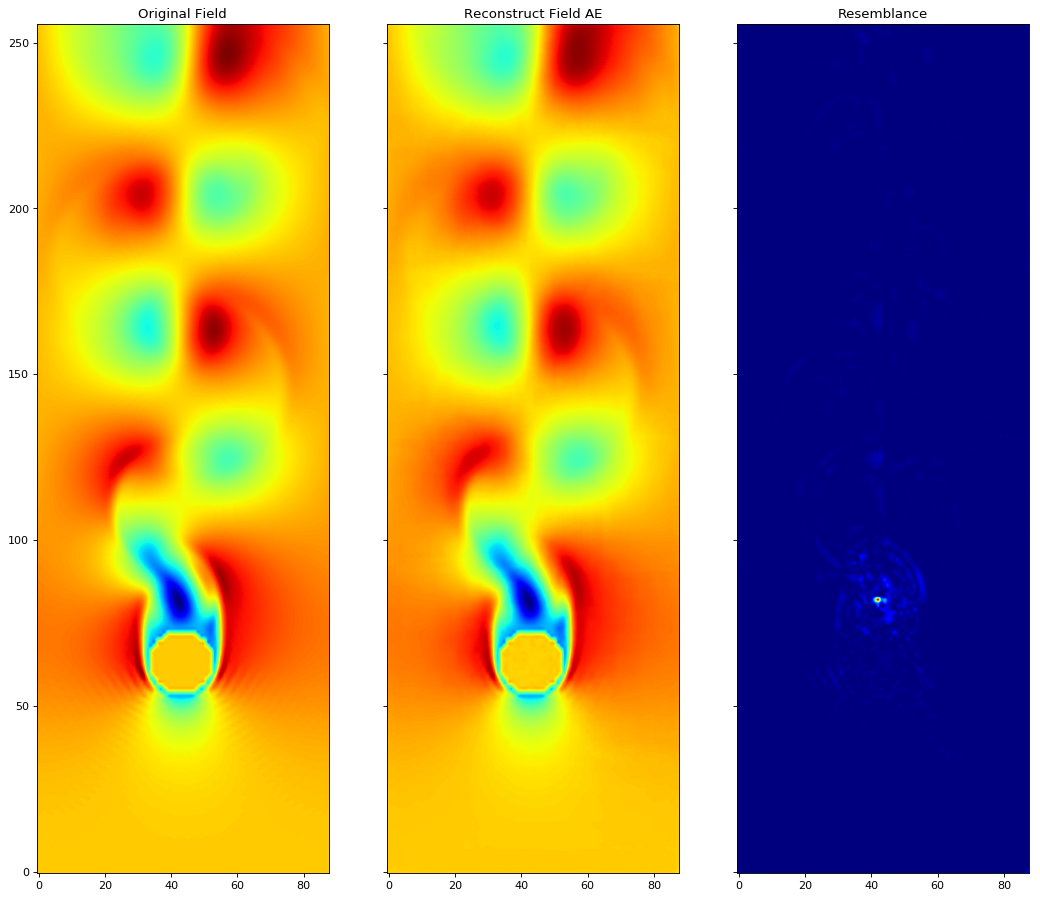

In [0]:
delta_t=0
dti=0
nt=500
ni=np.random.randint(0,nt)
#ni=99
print(f'snapshot {ni}')
n=0


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

tmp=np.squeeze(Ut[ni+delta_t,dti,:,:,n])
z_min, z_max = tmp.min(),tmp.max()
ax1.imshow(tmp, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
ax1.set_title('Original Field')
               
tmpi=np.squeeze(Renc[ni,:,:])                
ax2.imshow(tmpi, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
ax2.set_title('Reconstruct Field AE')

alp=np_resemblance(tmp, tmpi)
z_min, z_max = alp.min(),alp.max()
ax3.imshow(alp, cmap='jet', vmin=0, vmax=1, interpolation='spline16', origin='lower')
ax3.set_title('Resemblance')
#print(f'{z_min}_{z_max}_mean_{np.mean(alp)}')



## Error estimation

$Xori$: original field

$Xrec$: reconstructed field

\begin{align}
\phi^n & = 100 \times \int\int\frac{\sqrt{(Xrec^n - Xori^n)^2}}{Xori^n} dx dz
\end{align}

(0, 480)

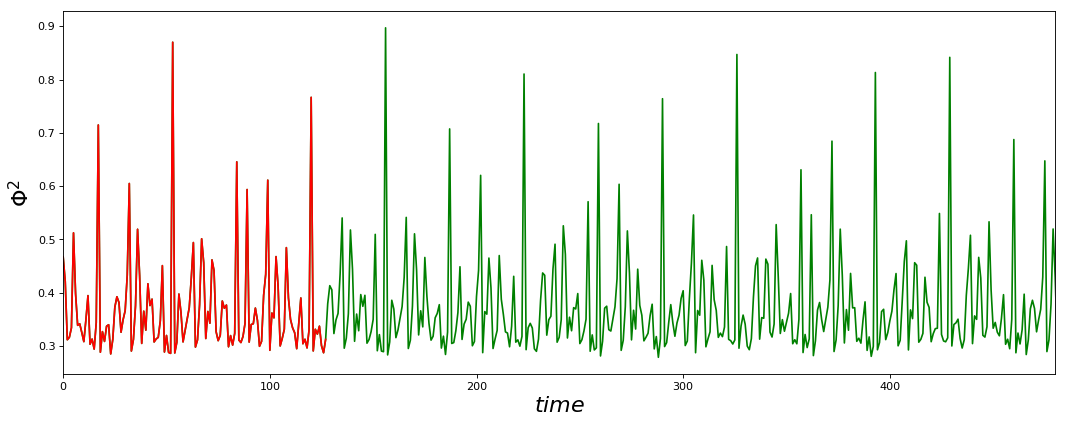

In [0]:
ix=0
n=0
VRenc=[]
VPod=[]
#dp=Ut[:,0,:,:,:]
xl=range(0,88)

for ni in range(Ut.shape[0]):
  ix +=1
  tmp=np.squeeze(Ut[ni+delta_t,0,:,:,n])  
  tmp2=np.squeeze(Renc[ni,:,:]) 
  val=0
  nn=1
  val=100*np.mean(abs(tmp2[:,xl]**nn - tmp[:,xl]**nn)/abs(tmp[:,xl]**nn))
  #np.shape(val)
  if ix==1:
    VRenc=val
  else:
    VRenc=np.vstack((VRenc,val))

    

_,ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax.plot(VRenc,'g-')
ax.plot(VRenc[:1*128],'r-')
ax.set_xlim(0,4*128)
ax.set_ylabel('$\Phi^2$', fontsize=20)
ax.set_xlabel('$time$', fontsize=20)
#ax.set_ylim(0,0.2)
ax.set_xlim(0,480)





## Comparaison with Proper Orthogonal Decomposition (POD)

In [0]:
from sklearn.decomposition import PCA
nl=3  # number of mode
pt=U[0:128,:,:,0]
nt,nr,nx=np.shape(pt)
ptmp=np.reshape(pt,[nt,nx*nr])

pca = PCA(n_components=nl)


pca = PCA(n_components=nl)
X_train_pca = pca.fit_transform(ptmp.T)

at=pca.components_
X1_pod = pca.inverse_transform(X_train_pca)
X1_pod=np.reshape(X1_pod,(nr,nx,-1))
X1_pod=np.transpose(X1_pod,(2,0,1))
#X1_pod=np.expand_dims(X1_pod,axis=3)


X_train_pca = pca.fit_transform(ptmp)

s = pca.explained_variance_



vp=pca.components_
nc=nl
vp=np.reshape(vp,(nc,nr,nx))

if 1==2:
  f, ax = plt.subplots(1, 4, sharey=True,figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

  plt.plot(s[:],'+-')
  ix=0
  for row in ax:
      tmp=np.squeeze(vp[ix,:,:])
      zmin=tmp.min()
      zmax=tmp.max()
      row.imshow(np.squeeze(tmp), cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', aspect='auto', origin='low')
      ix+=1
  print(ix)

In [0]:
delta_t=0
dti=0
nt=500
nt=128

ni=np.random.randint(0,nt)
print(f'snapshot {ni}')
n=0


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

tmp=np.squeeze(Ut[ni+delta_t,dti,:,:,n])
z_min, z_max = tmp.min(),tmp.max()
ax1.imshow(tmp, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
ax1.set_title('Original')

               
tmpi=np.squeeze(Renc[ni,:,:])                
ax2.imshow(tmpi, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
ax2.set_title('AE')

tmpi=np.squeeze(X1_pod[ni,:,:])                
ax3.imshow(tmpi, cmap='jet', vmin=0, vmax=1, interpolation='spline16', origin='lower')
ax3.set_title('POD')


snapshot 118


Text(0.5, 1.0, 'Resemblance with POD')

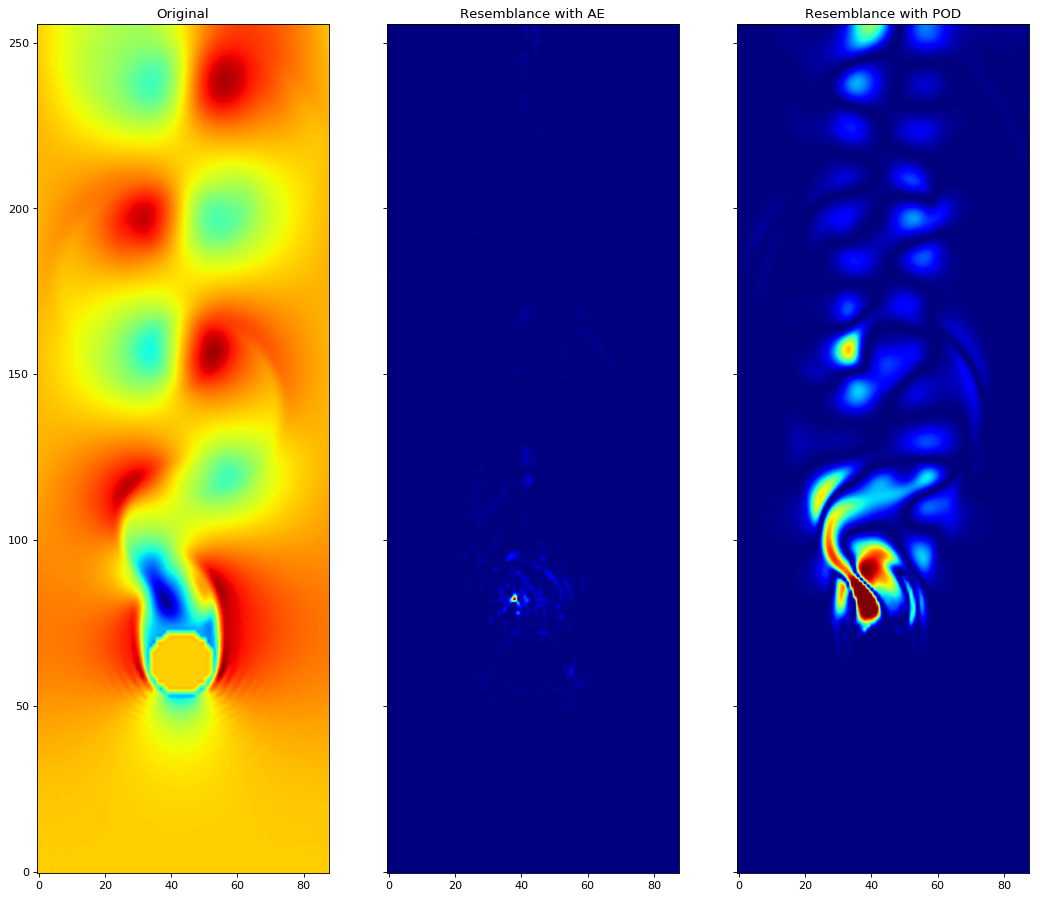

In [0]:
delta_t=0
dti=0
nt=500
nt=128

ni=np.random.randint(0,nt)
print(f'snapshot {ni}')
n=0


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

tmp=np.squeeze(Ut[ni+delta_t,dti,:,:,n])
z_min, z_max = tmp.min(),tmp.max()
ax1.imshow(tmp, cmap='jet', vmin=0, vmax=1, interpolation='spline16', origin='lower')
ax1.set_title('Original')

tmpi=np.squeeze(Renc[ni,:,:])                
alp=np_resemblance(tmp, tmpi)
z_min, z_max = alp.min(),alp.max()
ax2.imshow(alp, cmap='jet', vmin=0, vmax=1, interpolation='spline16', origin='lower')
ax2.set_title('Resemblance with AE')

tmpi=np.squeeze(X1_pod[ni,:,:]) 
alp=np_resemblance(tmp, tmpi)
ax3.imshow(alp, cmap='jet', vmin=0, vmax=1, interpolation='spline16', origin='lower')
ax3.set_title('Resemblance with POD')


Text(0.5, 0, '$time$')

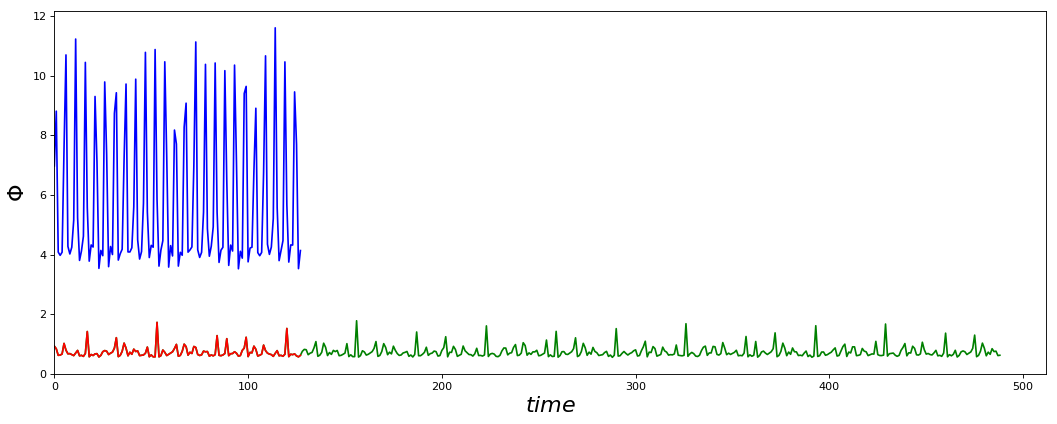

In [0]:
ix=0
n=0
VRenc=[]
VPod=[]
xl=range(0,88)

for ni in range(Ut.shape[0]):
  ix +=1
  tmp=np.squeeze(Ut[ni+delta_t,0,:,:,n])  
  tmp2=np.squeeze(Renc[ni,:,:]) 
  if ix<129:
    tmp3=np.squeeze(X1_pod[ni,:,:]) 
  
  nn=2
  val=0
  val=100*np.mean(abs(tmp2[:,xl]**nn - tmp[:,xl]**nn)/abs(tmp[:,xl]**nn))
  valp=0
  valp=100*np.mean(abs(tmp3[:,xl]**nn - tmp[:,xl]**nn)/abs(tmp[:,xl]**nn))

  #np.shape(val)
  if ix==1:
    VRenc=val
    VPod=valp
  
  else:
    VRenc=np.vstack((VRenc,val))
    VPod=np.vstack((VPod,valp))

    

_,ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax.plot(VRenc,'g-')
ax.plot(VRenc[:1*128],'r-') # Red line - AE
ax.plot(VPod[:1*128],'b-')  # Blue line - POD

ax.set_xlim(0,4*128)
ax.set_ylabel('$\Phi$', fontsize=20)
ax.set_xlabel('$time$', fontsize=20)
#ax.set_ylim(0,0.2)


# Caracterisation of temporal relation of Latent components




## Spectral analysis 



/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 1024 is greater than input length  = 489, using nperseg = 489
  .format(nperseg, input_length))
/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 1024 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


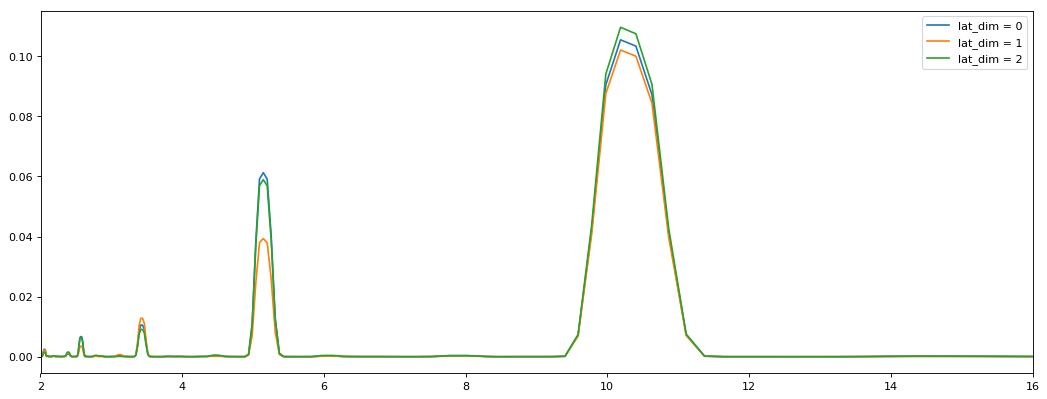

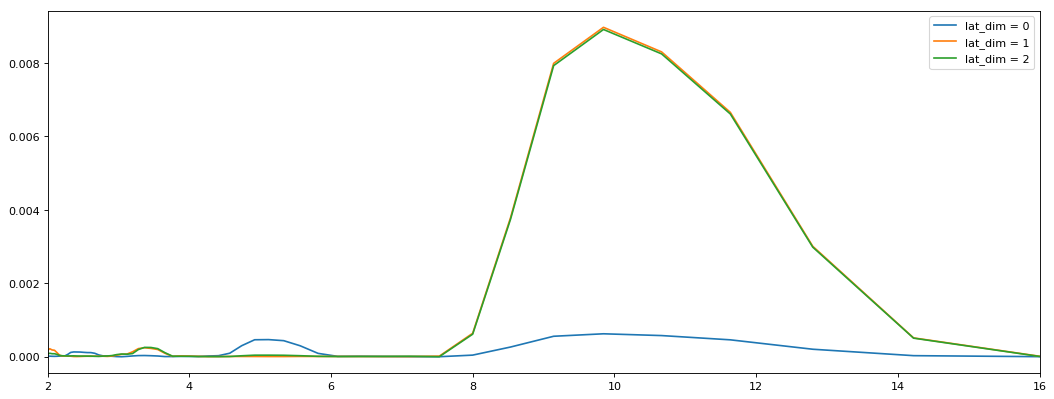

In [0]:
from scipy import signal

nt,nc=np.shape(Zenc)

_, ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
fs=1
for i in range(nc):
    #print(i)
    data=Zenc[:,i]
   
    f, Pxx = signal.welch(data, fs, 'flattop', 1024/1, scaling='spectrum')
    #ax = plt.subplot(111)
    #fPxx=f*Pxx
    fPxx=1*Pxx
    tm=fPxx.max()
    
    #ax.semilogx(1/f[1:], fPxx[1:], label=f'lat_dim = {i}')
    ax.plot(1/f[1:], f[1:]*np.sqrt(Pxx[1:]), label=f'lat_dim = {i}')
    ax.set_xlim(1/f[-1],16)
    ax.legend()
    
    
    
   

_, ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
fs=1
for i in range(nc):
    #print(i)
    data=at[i,:]
   
    f, Pxx = signal.welch(data, fs, 'flattop', 1024/1, scaling='spectrum')
    #ax.semilogx(1/f[1:], fPxx[1:], label=f'lat_dim = {i}')
    ax.plot(1/f[1:], f[1:]*np.sqrt(Pxx[1:]), label=f'lat_dim = {i}')
    ax.set_xlim(1/f[-1],16)
    ax.legend()


## Heatmap correlation

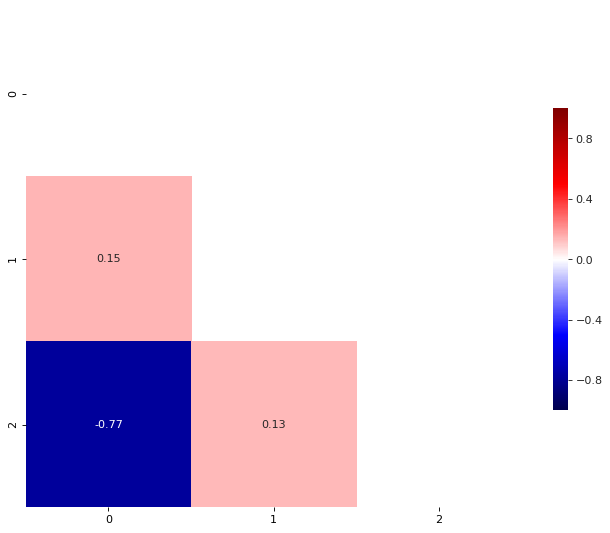

In [0]:
import seaborn as sns
corr = np.corrcoef(Zenc.T)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



_, ax = plt.subplots(1, 1, sharey=True,figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, square=True, cmap="seismic", cbar_kws={"shrink": .5})

## Coherence

0
1
2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


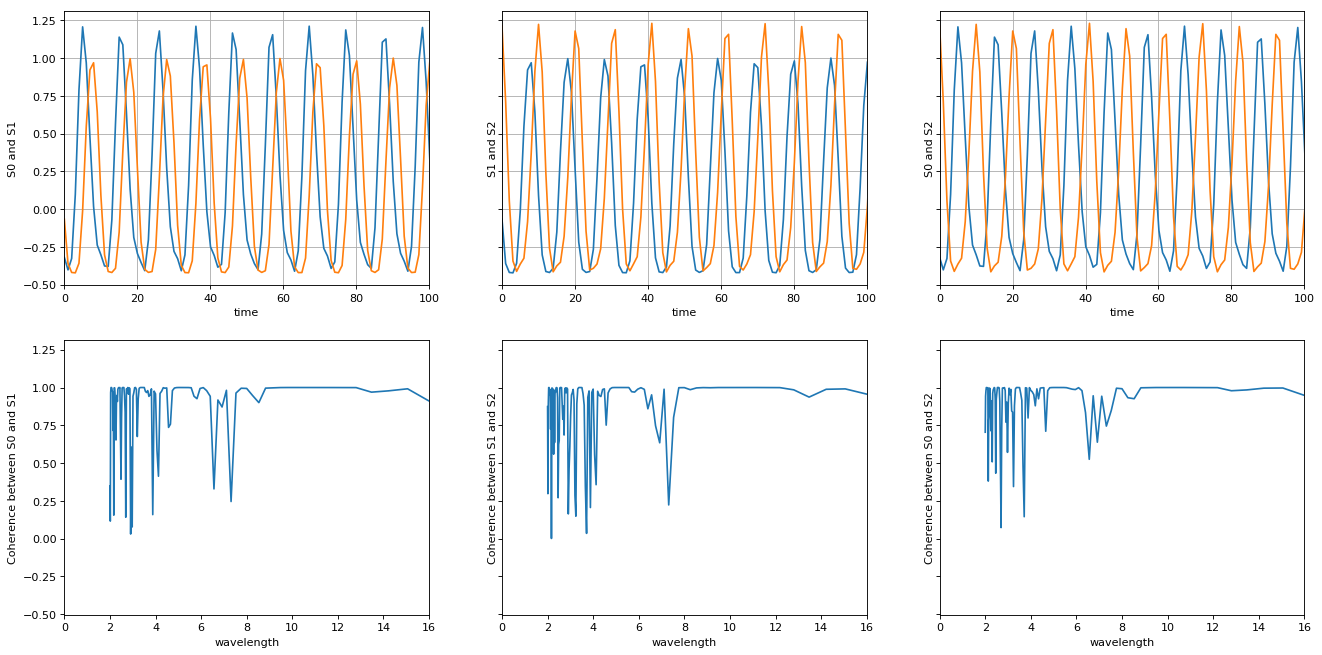

In [0]:
#@title Coherence between signals from latent space
window_size = 256 #@param {type:"slider", min:0, max:2048, step:32}

dt = 1
fs=1/dt


xt=np.linspace(0,nt*dt,nt)

fig, axs = plt.subplots(2, 3, sharey=True,figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')


for k in np.arange(3):
  #fig, axs = plt.subplots(2, 3)
  print(f'{k}')
  if k==0:
    n1=0
    n2=1
  elif k==1:
    n1=1
    n2=2
  else:
    n1=0
    n2=2

  s1 = Zenc[:,n1]
  s2 = Zenc[:,n2]


  axs[0,k].plot(xt, s1/2, xt, s2/2)
  axs[0,k].set_xlim(0, 100)
  #axs[0,k].set_ylim(-5,5)

  axs[0,k].set_xlabel('time')
  tt=f'S{n1} and S{n2}'
  axs[0,k].set_ylabel(tt)
  axs[0,k].grid(True)
  win=window_size
  f,cxy = signal.coherence(s1, s2, fs, nperseg=win ,noverlap = win // 2.)
  #axs[1,k].semilogx(1/f, cxy)
  axs[1,k].plot(1/f, cxy)
  tt=f'Coherence between S{n1} and S{n2}'
  axs[1,k].set_ylabel(tt)
  axs[1,k].set_xlim(0,16)
  axs[1,k].set_xlabel('wavelength')
  #axs[1,k].set_ylim([-0.2,1.1])


#fig.tight_layout()
#plt.show()    




##Joint Pdfs - showing no linear relation 

0
1
2


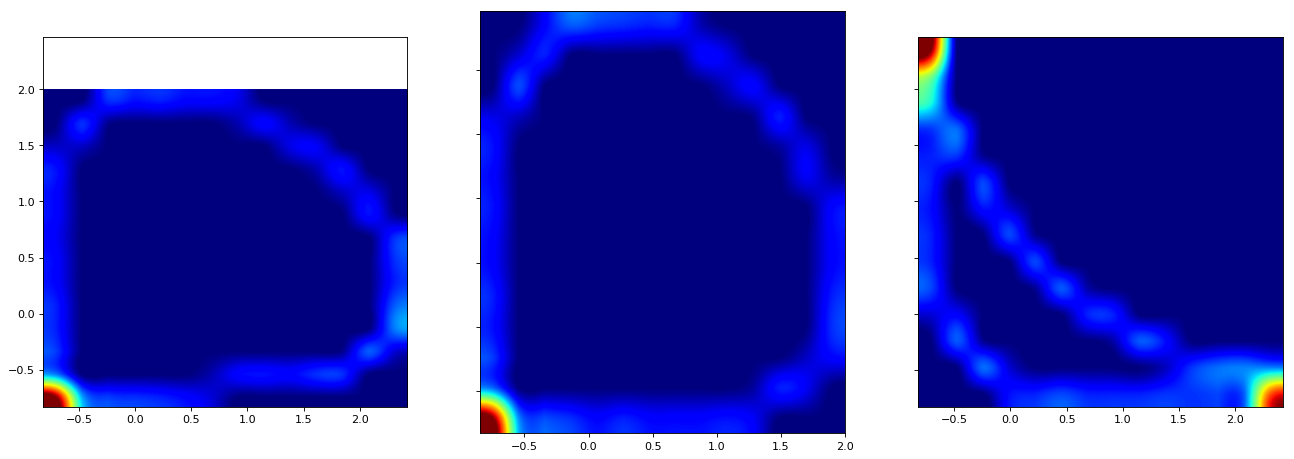

In [0]:

fig, axs = plt.subplots(1, 3, sharey=True,figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')


for k in np.arange(3):
  #fig, axs = plt.subplots(2, 3)
  print(f'{k}')
  if k==0:
    n1=0
    n2=1
  elif k==1:
    n1=1
    n2=2
  else:
    n1=0
    n2=2

  s1 = Zenc[:,n1]
  s2 = Zenc[:,n2]


  H, xedges, yedges = np.histogram2d(Zenc[:,n1], Zenc[:,n2], bins=(14,14))
  #plt.imshow(H, interpolation='none', aspect='equal',origin='low',cmap='jet', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

  axs[k].imshow(H, interpolation='spline16', aspect='equal', origin='low',cmap='jet', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

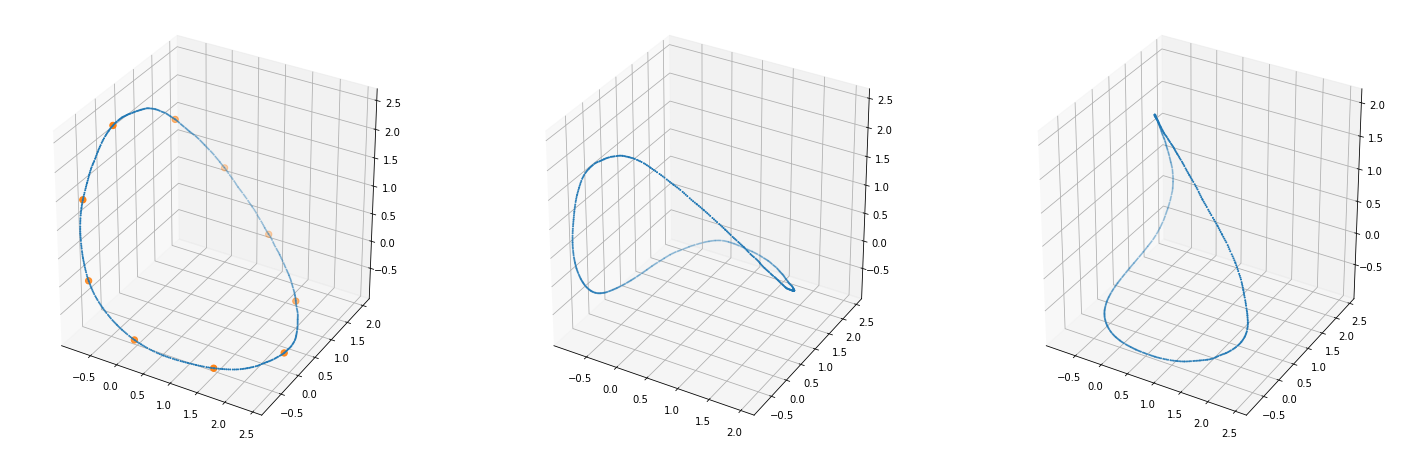

In [0]:
from mpl_toolkits.mplot3d import Axes3D
u=Zenc
fig = plt.figure(figsize=(25, 8))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(u[:,0], u[:,1], u[:,2], s=1)
k=10
ax.scatter(u[:k,0], u[:k,1], u[:k,2], s=40)
  
ax = fig.add_subplot(132, projection='3d')
ax.scatter(u[:,1], u[:,2], u[:,0], s=1)

ax = fig.add_subplot(133, projection='3d')
ax.scatter(u[:,2], u[:,0], u[:,1], s=1)
